# Selecting Praesepe members, compiling data and fitting a gyrochronology relation

This notebook reproduces figures in the paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from astropy.io import fits

plotpar = {'axes.labelsize': 40,
           'font.size': 30,
           'legend.fontsize': 30,
           'xtick.labelsize': 40,
           'ytick.labelsize': 40,
           'text.usetex': True}
plt.rcParams.update(plotpar)

Load the Douglas Praesepe rotation period catalog.

In [3]:
douglas = pd.read_csv("../../data/praesepe_douglas.csv", skiprows=89)
douglas.head()

,Name,EPIC,Mass,r'mag,Kmag,Prot1,Pw1,Q1,Clean?,Sig,...,SmAmp,P,Kpmag,PrCat,PCat,All,2M,Simbad,_RA,_DE
0,KW547,211898181,1.05,11.65,9.70,,,2,,,...,,,11.68,0,0,All,2M,Simbad,130.157851,18.700121
1,A 448,211845572,0.15,18.59,14.57,,,2,,,...,,,17.36,0,0,All,2M,Simbad,129.143078,17.957611
2,KW548,212004731,0.80,11.81,10.59,3.96,0.1085,0,N,0.00838,...,0.02363,2,11.79,0,0,All,2M,Simbad,130.815494,20.333748
3,JC201,211930461,0.73,13.49,10.76,14.59,0.8391,0,Y,0.00816,...,0.38429,2,13.49,0,1,All,2M,Simbad,130.088905,19.181773
4,,212094548,0.16,19.52,14.25,6.60,0.0089,1,N,0.00521,...,0.77485,2,18.71,0,1,All,2M,Simbad,130.281121,21.915739


Format the data: convert periods from strings to floats and get rid of spaces in the dataframe

In [4]:
periods = []
for p in douglas.Prot1.values:
    if p == "     ":
        periods.append(0.)
    else:
        periods.append(float(p))
douglas["period"] = np.array(periods)

Load the Bedell Gaia-K2 crossmatch (downloaded from gaia-kepler.fun) and ensmallen it so it's a managable size.

In [5]:
with fits.open('../../data/k2_dr2_1arcsec.fits') as data:
    bedell = pd.DataFrame(data[1].data)
bedell.keys()

c5_mask = bedell.k2_campaign_str.values == "5"
c5 = pd.DataFrame(dict({"source_id": bedell.source_id.values[c5_mask], 
                        "EPIC": bedell.epic_number.values[c5_mask], 
                        "ra": bedell.ra.values[c5_mask], 
                        "dec": bedell.dec.values[c5_mask], 
                        "G": bedell.phot_g_mean_mag.values[c5_mask],
                        "bp": bedell.phot_bp_mean_mag.values[c5_mask],
                        "rp": bedell.phot_rp_mean_mag.values[c5_mask],
                        "parallax": bedell.parallax.values[c5_mask],
                        "parallax_err": bedell.parallax_error.values[c5_mask],
                       }))

Text(0,0.5,'Dec')

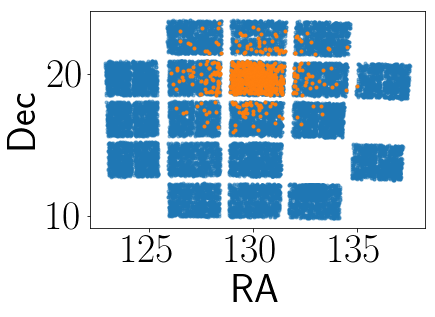

In [6]:
plt.plot(c5.ra, c5.dec, ".", alpha=.5)
plt.plot(douglas._RA, douglas._DE, ".")
plt.xlabel("RA")
plt.ylabel("Dec")

Just plot the crossmatched stars.

In [7]:
df = pd.merge(c5, douglas, on="EPIC", how="inner")
df.drop_duplicates("EPIC", inplace=True)
print(np.shape(c5), np.shape(douglas), np.shape(df))

(27500, 9) (794, 29) (757, 37)


Text(0,0.5,'Dec')

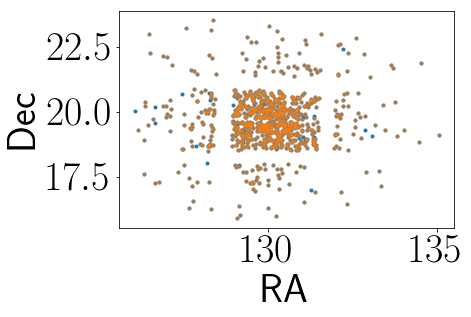

In [8]:
plt.plot(douglas._RA, douglas._DE, ".")
plt.plot(df.ra, df.dec, ".", alpha=.5)
plt.xlabel("RA")
plt.ylabel("Dec")

In [9]:
df.keys()

Index(['EPIC', 'G', 'bp', 'dec', 'parallax', 'parallax_err', 'ra', 'rp',
       'source_id', 'Name', 'Mass', 'r'mag', 'Kmag', 'Prot1', 'Pw1', 'Q1',
       'Clean?', 'Sig', 'Prot2', 'Pw2', 'Q2', 'MP?', 'SE?', 'Bl?', 'Bin?',
       'RawAmp', 'SmAmp', 'P', 'Kpmag', 'PrCat', 'PCat', 'All', '2M', 'Simbad',
       '_RA', '_DE', 'period'],
      dtype='object')

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


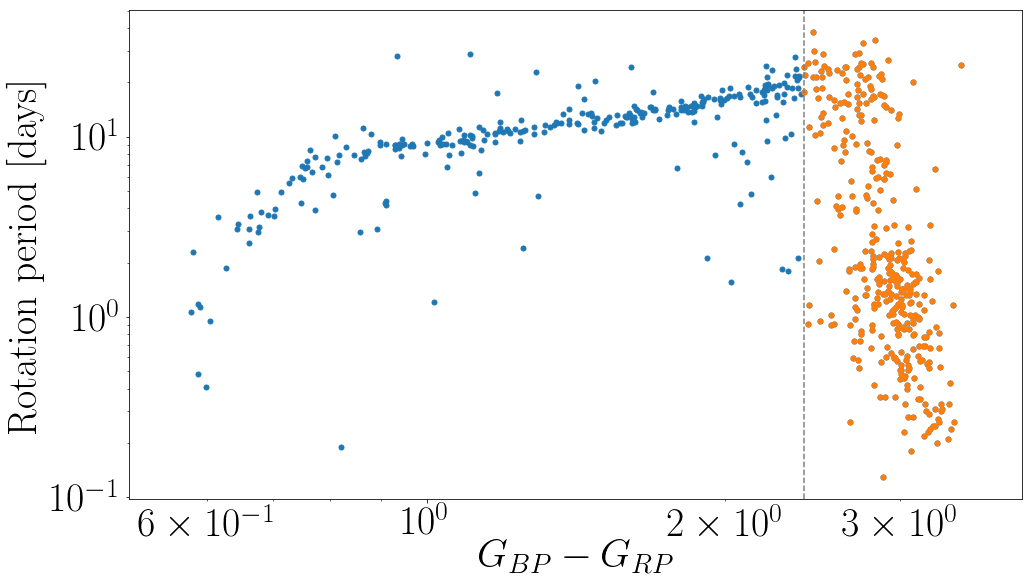

In [10]:
gaia_color = df.bp - df.rp
Mdwarf_cut = 2.4
color_mask = gaia_color < Mdwarf_cut

plt.figure(figsize=(16, 9))
plt.loglog(gaia_color, df.period, ".", ms=10)
plt.loglog(gaia_color[~color_mask], df.period[~color_mask], ".", color="tab:orange", ms=10)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.xlim(10**-.3, 10**.6)
plt.axvline(Mdwarf_cut, color=".5", ls="--")
plt.savefig("../praesepe.pdf")

Iteratively remove outliers.

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


(-1, 1.7)

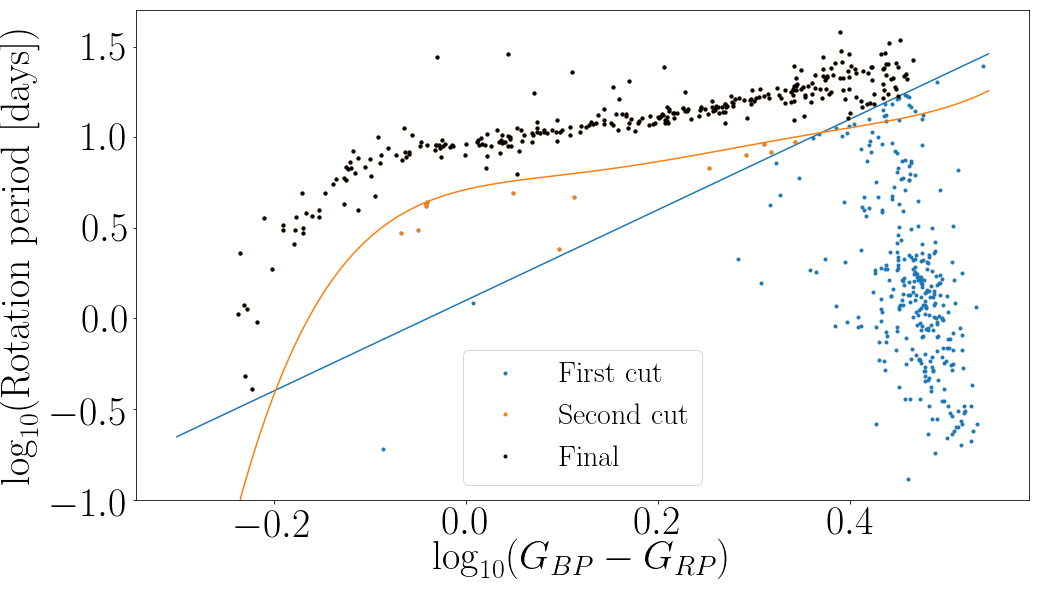

In [86]:
plt.figure(figsize=(16, 9))
plt.plot(np.log10(gaia_color), np.log10(df.period), ".", label="$\mathrm{First~cut}$")
plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$")

xs = np.linspace(np.log10(.5), np.log10(3.5), 100)
plt.plot(xs, 2.5*xs + .1, color="tab:blue")

m = 2.5*np.log10(gaia_color) + .1 < np.log10(df.period) 
plt.plot(np.log10(gaia_color[m]), np.log10(df.period[m]), ".", label="$\mathrm{Second~cut}$")

A = np.vander(np.log10(gaia_color[m]), 6)
ATA = np.dot(A.T, A)
pr = np.linalg.solve(ATA, np.dot(A.T, np.log10(df.period[m])))

plt.plot(xs, np.polyval(pr, xs-.05) - .2, color="tab:orange")

mpr = np.log10(df.period[m]) > np.polyval(pr, np.log10(gaia_color[m])-.05) - .2
plt.plot(np.log10(gaia_color[m][mpr]), np.log10(df.period[m][mpr]), "k.", label="$\mathrm{Final}$")

plt.legend()
plt.ylim(-1, 1.7)

In [136]:
# plt.figure(figsize=(16, 9))
# m_mask = gaia_color < 2.4
# plt.plot(np.log10(gaia_color[m_mask]), np.log10(df.period[m_mask]), ".", label="$\mathrm{First~cut}$")
# plt.xlabel("$\log_{10}(G_{BP} - G_{RP})$")
# plt.ylabel("$\log_{10}(\mathrm{Rotation~period~[days]})$")

def sigma_clip(x, y):
    finite_mask = np.isfinite(x) * np.isfinite(y)
    x, y = x[finite_mask], y[finite_mask]
    new_x, new_y = x*1, y*1
    
    for i in range(10):
        A = np.vander(new_x, 6)
        ATA = np.dot(A.T, A)
        pr = np.linalg.solve(ATA, np.dot(A.T, new_y))
        y_pred = np.polyval(pr, new_x)
        sigma = np.std(np.abs(new_y - y_pred))
        outlier_mask = np.abs(new_y - y_pred) < 2*sigma
        new_x, new_y = new_x[outlier_mask], new_y[outlier_mask]
    
    return x[outlier_mask], y[outlier_mask]

x_clipped, y_clipped = sigma_clip(np.log10(gaia_color[m_mask]), np.log10(df.period[m_mask]))
plt.plot(np.log10(gaia_color[m_mask]), np.log10(df.period[m_mask]), ".")
plt.plot(x_clipped, y_clipped, ".")

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/Users/ruthangus/anaconda/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

Now fit a model

In [107]:
praesepe_age = 625
sun_age, sun_prot, sun_color = np.array([4.56]), np.array([26]), np.array([.82])

x = np.concatenate((np.log10(gaia_color[m][mpr]), np.log10(sun_color)))
y = np.concatenate((np.log10(df.period[m][mpr]), np.log10(sun_prot)))
z = np.concatenate((np.log10(np.ones_like(gaia_color[m][mpr])*praesepe_age), np.log10(sun_age)))

finite_mask = np.isfinite(x) * np.isfinite(y) * np.isfinite(z)
x, y, z = x[finite_mask], y[finite_mask], z[finite_mask]

sigma = z*.1  # 10% uncertainties
sigma[-1] = sun_age * .01 # 1% uncertainty for the Sun 

AT = np.vstack((np.ones(len(x)), x, x**2, x**3, x**4, z))
ATA = np.dot(AT, AT.T)
p = np.linalg.solve(ATA, np.dot(AT, y))
p

array([  1.71339061,   0.78762248,  -5.72281667,  29.55181735,
       -37.9884422 ,  -0.2534441 ])

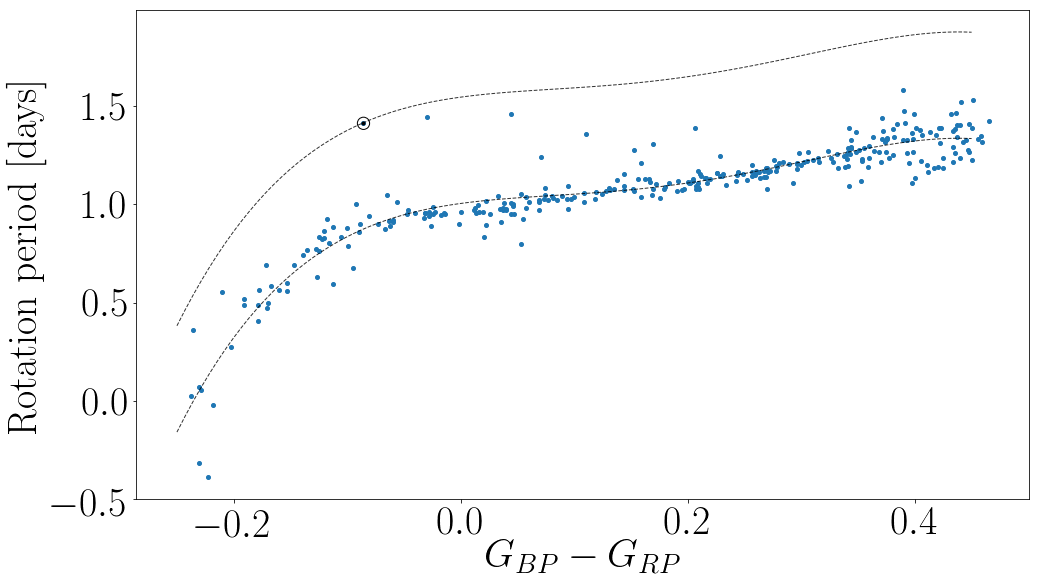

In [116]:
plt.figure(figsize=(16, 9))
plt.plot(x, y, ".", ms=8, zorder=0)
plt.plot(np.log10(sun_color), np.log10(sun_prot), ".k", zorder=0)  # Casagrande 2018
plt.scatter(np.log10(sun_color)+.0005, np.log10(sun_prot)-.002, s=150, 
            facecolors="none", edgecolors="k", zorder=0)
plt.xlabel("$G_{BP} - G_{RP}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

xs = np.linspace(-.25, .45, 100)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(praesepe_age),
         color="k", ls="--", lw=1, zorder=0, alpha=.8)
plt.plot(xs, p[0] + p[1]*xs + p[2]*xs**2 + p[3]*xs**3 + p[4]*xs**4 + p[5]*np.log10(sun_age),
         color="k", ls="--", lw=1, zorder=0, alpha=.8)